In [1]:
import matplotlib.pyplot as plt
import pickle
import os
import math
import numpy as np
from od.social import SocialGroup
from od.network.types import ResourceAllocatorType,BaseStationType
from od.misc.interest import InterestConfig
from od.misc.statistic import NetFlowType
from numpy import random
plt.rcParams.update(
    {
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "legend.loc":"upper left",
    "legend.framealpha":0.3,
    "font.size":14,
    }
)

In [2]:
def GetLineMarkerStyle(line_no):
    line_style = ['--','-.',':']
    marker_style = ['o','v','^','<','>','s','p','*','h','H','x','D']
    line_no = line_no % (len(line_style)*len(marker_style))
    return marker_style[int(line_no%len(marker_style))] + line_style[int(line_no/(len(marker_style)))]
#     return marker_style[int(line_no/len(line_style))] + line_style[int(line_no%(len(line_style)))]

In [3]:
nsg_graph_configs = [
    {
        "catalog": "bs_through_put",
        "topic": "Throughput",
        "x": "Traffic Scale",
        "y": "Megabits",
        "subject": [bs_type for bs_type in BaseStationType]
    },
    
]


In [4]:
bs_sg_graph_configs = [
    {
        "catalog": "bs_sg_res_use_rate",
        "topic": "Social-Group Traffic Service Ratio",
        "x": "Traffic Scale",
        "y": "%",
        "subject": [bs_type for bs_type in BaseStationType]
    },
]



In [5]:
sys_graph_configs = [
    {
        "catalog": "sys_through_put",
        "topic": "Throughput",
        "x": "Traffic Scale",
        "y": "Megabits",
    },
]

In [6]:
bs_names = {
    BaseStationType.UMA: "4G-eNB",
    BaseStationType.UMI: "5G-gNB",
}

In [7]:
def ExtractAbbreviations(abbrev):
    if(abbrev.lower() == "avg"):
        return "Average"
    elif(abbrev.lower() == "max"):
        return "Maximum"
    elif(abbrev.lower() == "min"):
        return "Minimum"

In [8]:
def BaseStationScenario(with_rsu):
    if(with_rsu):
        return "4G+5G"
    else:
        return  "4G"

In [55]:
def AdjustResAllocTypeName(alloc_type):
    if(alloc_type == ResourceAllocatorType.OMA):
        return "OMA"
    elif(alloc_type == ResourceAllocatorType.NOMA_OPT):
        return "NOMA"

In [19]:
seed_range = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
             ]
res_alloc_type_range = [t for t in ResourceAllocatorType]
req_rsu_range = [False, True]
traffic_scale_range = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]

In [20]:
import os
os.getcwd()

'/home/OD/repos/ProjectSumo'

In [56]:
interest_config = InterestConfig(None, False, 0)
stats = {
        seed:{
        res_alloc_type :{
            req_rsu:{
                traffic_scale: None 
                for traffic_scale in traffic_scale_range
            }
            for req_rsu in req_rsu_range
        }
        for res_alloc_type in res_alloc_type_range
    }
    for seed in seed_range
}
for seed in seed_range:
    for res_alloc_type in res_alloc_type_range:
        for req_rsu in req_rsu_range:
            for traffic_scale in traffic_scale_range:
                interest_config.res_alloc_type = res_alloc_type
                interest_config.req_rsu = req_rsu
                interest_config.traffic_scale = traffic_scale
                try:
                    with open("data/{}/{}/report_adjust_wait_time.pickle".format(seed,str(interest_config)), "rb") as file:
                        stats[seed][res_alloc_type][req_rsu][traffic_scale] = pickle.load(file)
                except:
                    print("missing: {} seed({})".format(str(interest_config),seed))

In [57]:
# create picture folder
dirpath = "pics/"
if not os.path.isdir(dirpath):
    os.mkdir(dirpath)

<ipython-input-60-89eed56fecea>:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(serial, figsize=(9, 5))


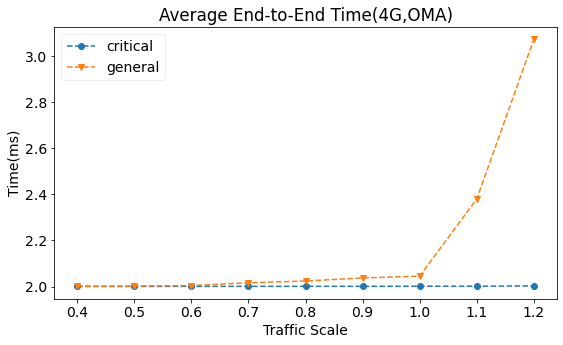

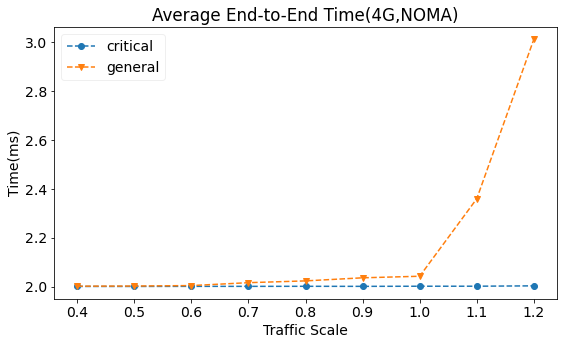

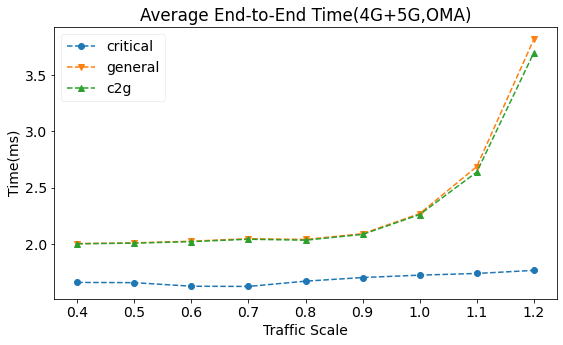

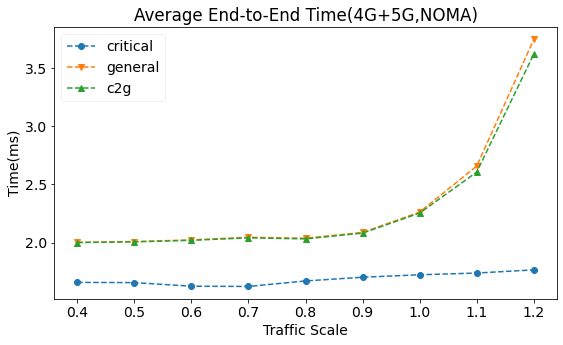

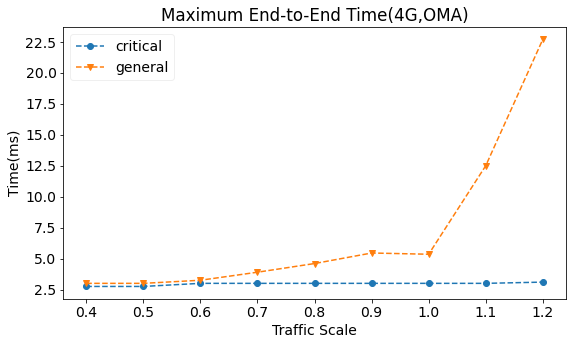

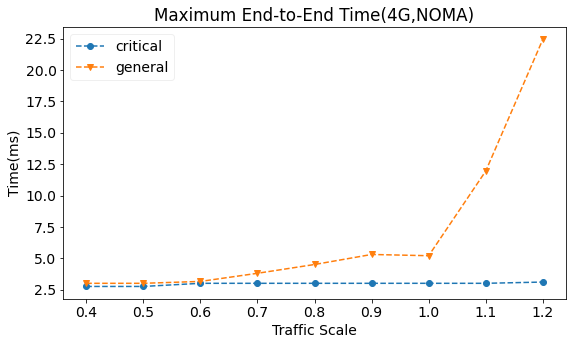

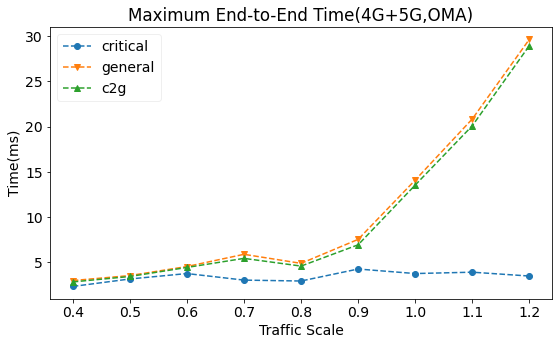

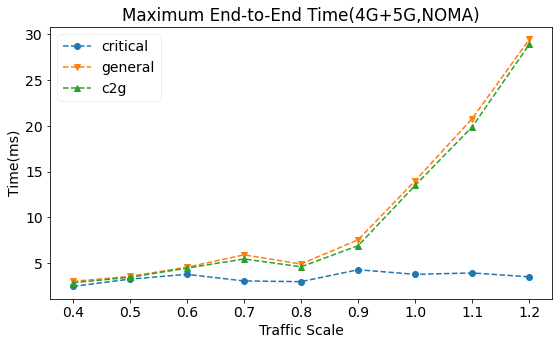

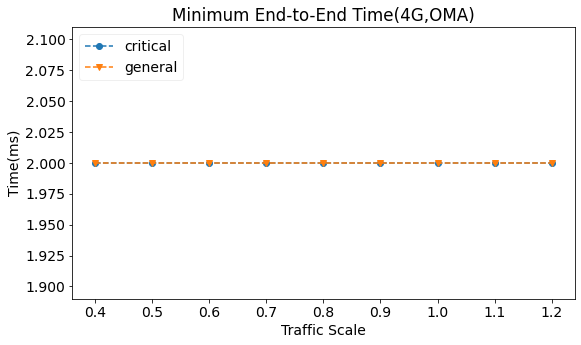

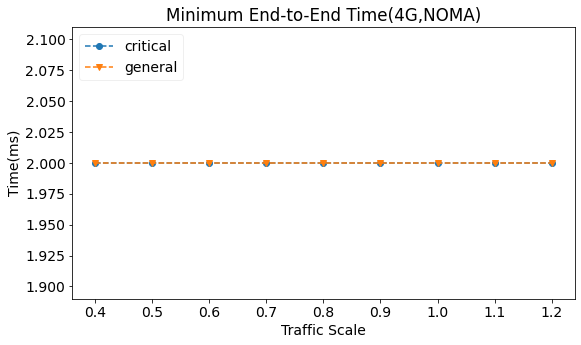

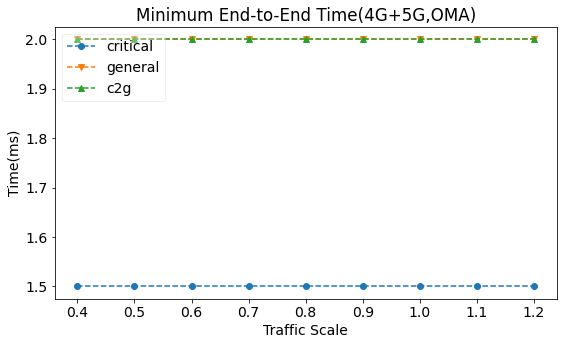

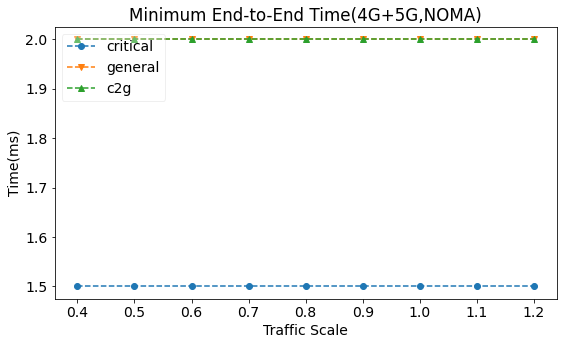

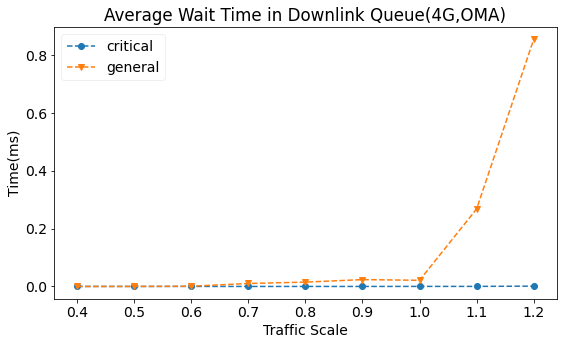

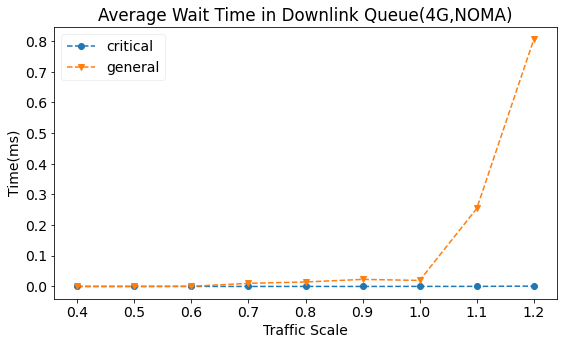

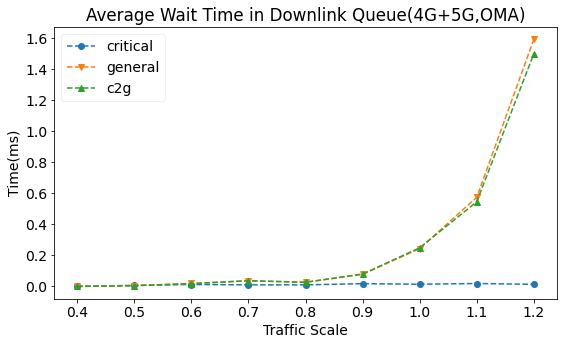

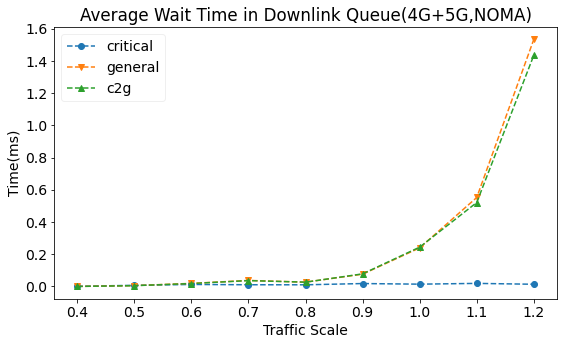

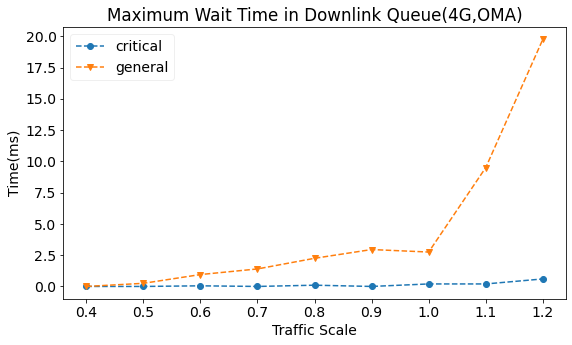

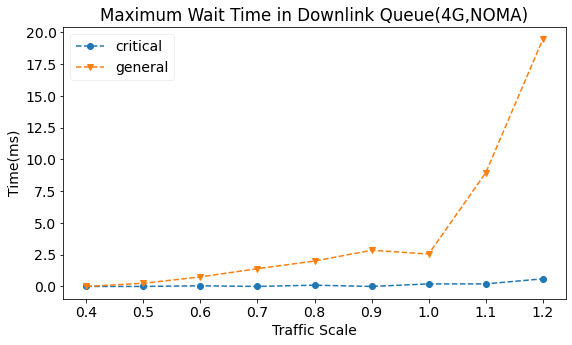

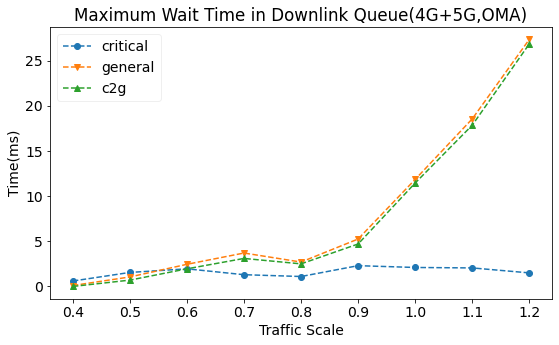

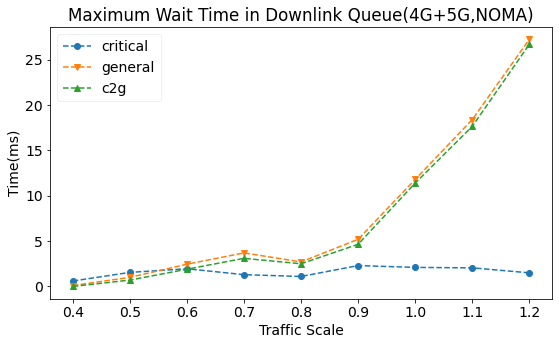

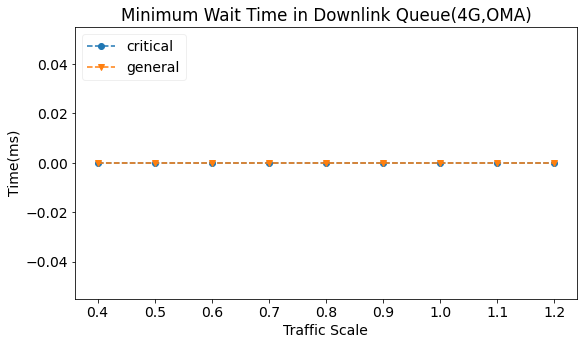

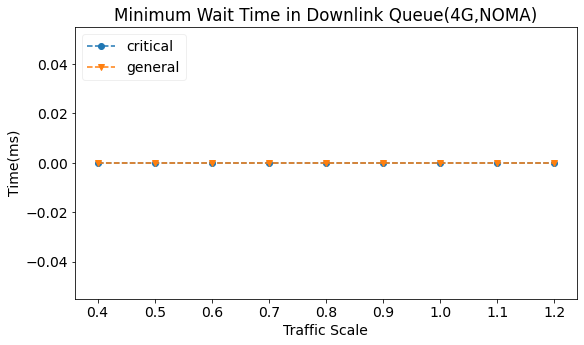

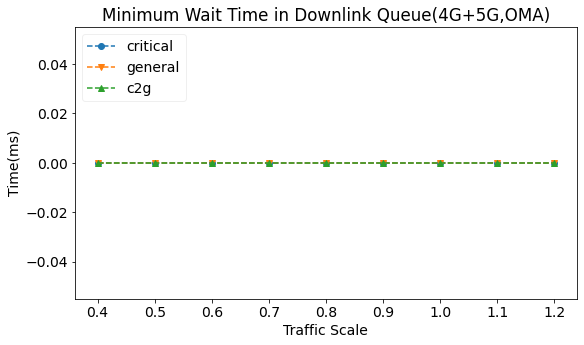

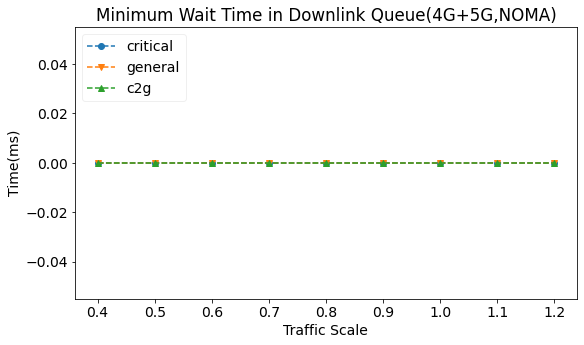

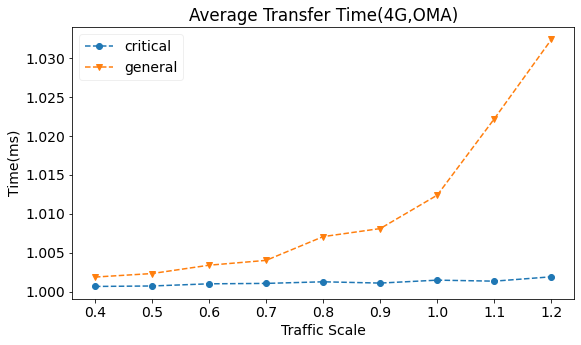

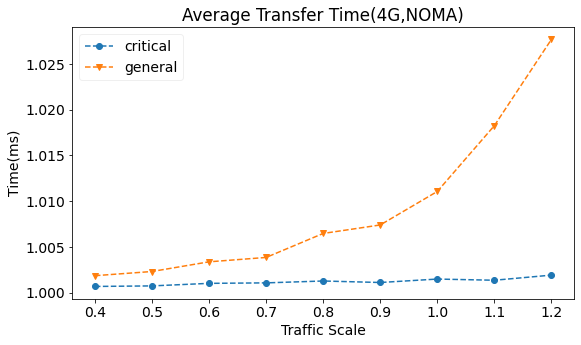

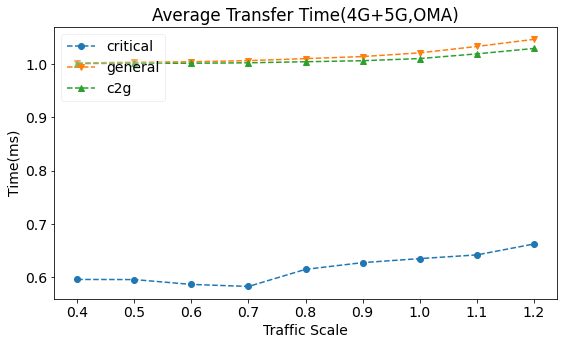

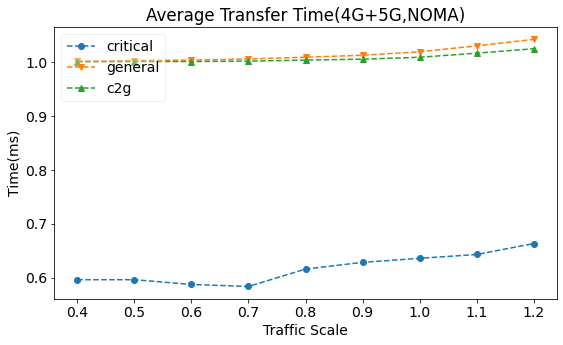

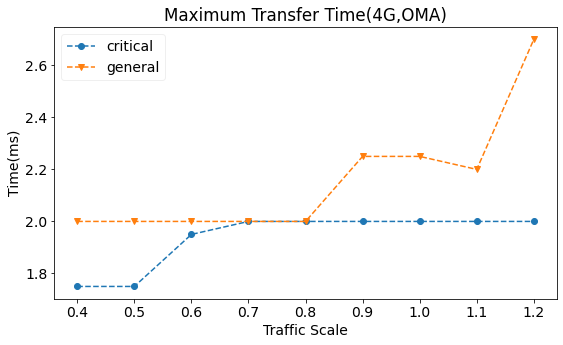

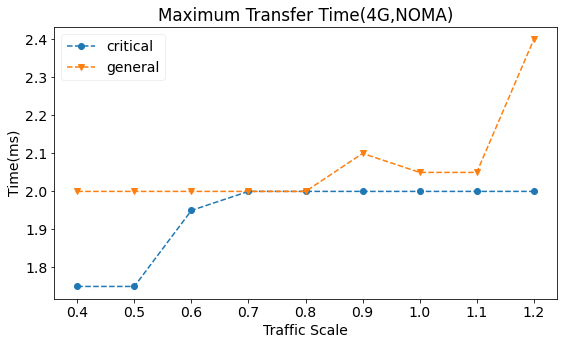

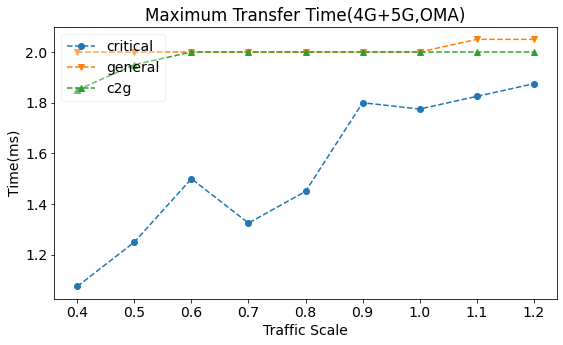

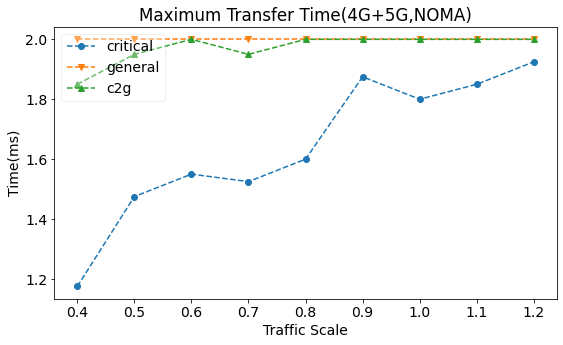

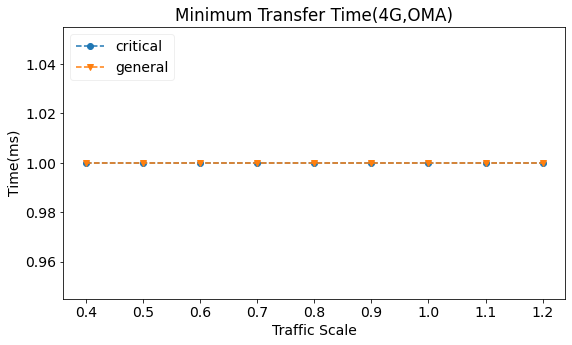

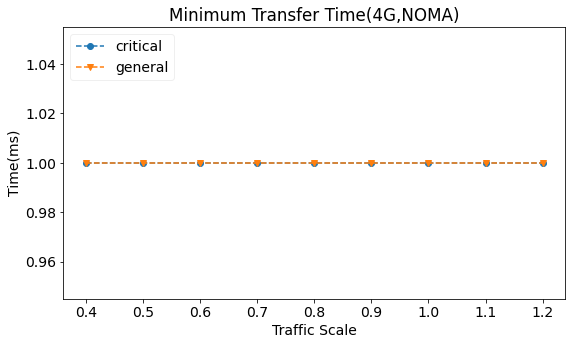

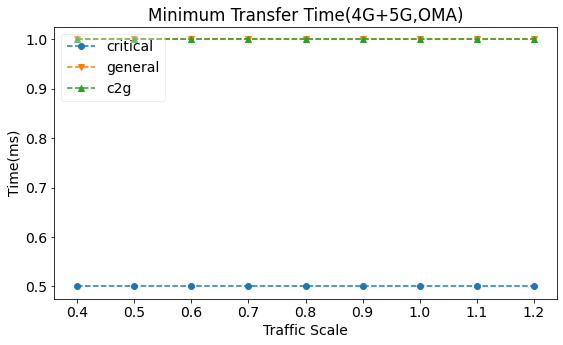

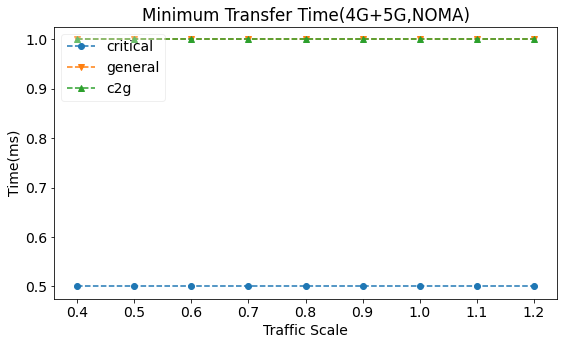

In [60]:
configs = [
    {
        "catalog": "end-to-end",
        "topic": "End-to-End Time",
        "x": "Traffic Scale",
        "y": "Time(ms)",
        "subject": ["avg", "max", "min"]
    },
    {
        "catalog": "wait-time",
        "topic": "Wait Time in Downlink Queue",
        "x": "Traffic Scale",
        "y": "Time(ms)",
        "subject": ["avg", "max", "min"]
    },
    {
        "catalog": "tx-time",
        "topic": "Transfer Time",
        "x": "Traffic Scale",
        "y": "Time(ms)",
        "subject": ["avg", "max", "min"]
    },
]


# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for req_rsu in req_rsu_range:
            for res_alloc_type in ResourceAllocatorType:
                title = "{} {}({},{})".format(
                    ExtractAbbreviations(subject), 
                    topic,
                    BaseStationScenario(req_rsu),
                    AdjustResAllocTypeName(res_alloc_type)
                )
                plt.figure(serial, figsize=(9, 5))
                plt.xlabel(config["x"])
                plt.ylabel(config["y"])
                plt.title(title)
                line_no = 0
                for nft in NetFlowType if req_rsu else [NetFlowType.CRITICAL, NetFlowType.GENERAL]:
                    y = []
                    x = traffic_scale_range
                    for traffic_scale in traffic_scale_range:
                        value = []
                        for seed in seed_range:
                            v = stats[seed][res_alloc_type][req_rsu][traffic_scale][catalog][nft.name][subject]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v*1000)
                        y.append(sum(value)/len(value))
                    plt.plot(
                        x,
                        y,
                        GetLineMarkerStyle(line_no),
                        label="{}".format(
                              nft.name.lower(),
                        )
                    )
                    line_no += 1
                plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
                plt.savefig('{}/{}.pdf'.format(dirpath, title))
                serial += 1
plt.show()


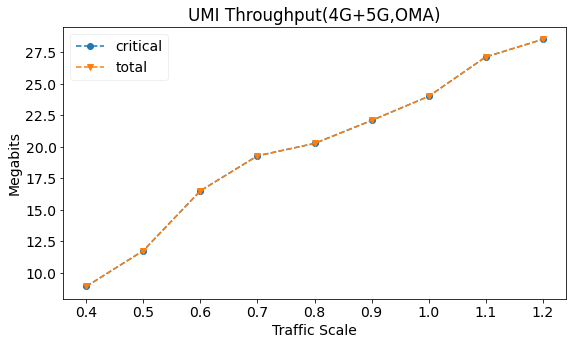

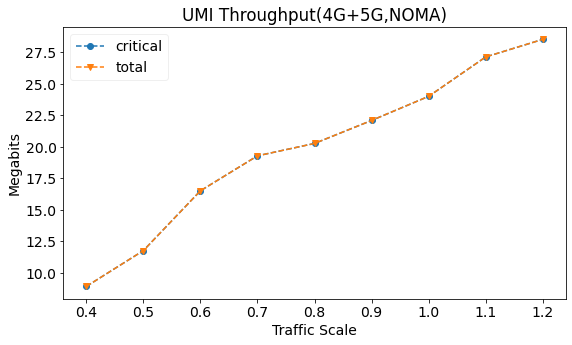

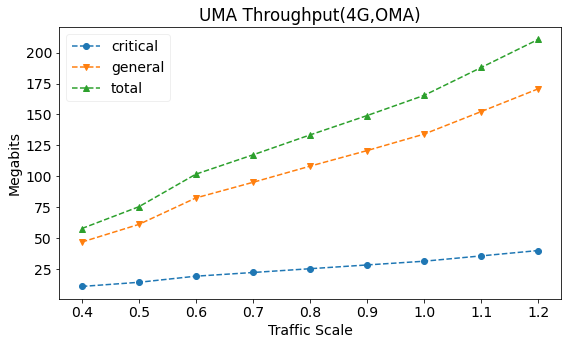

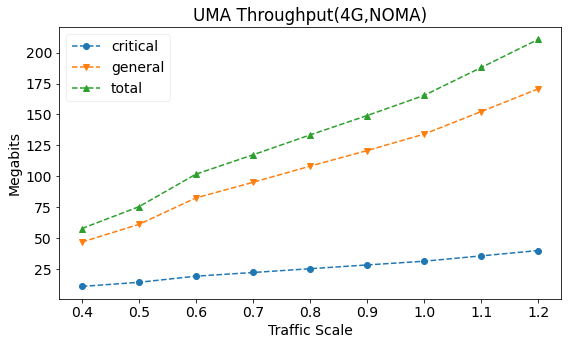

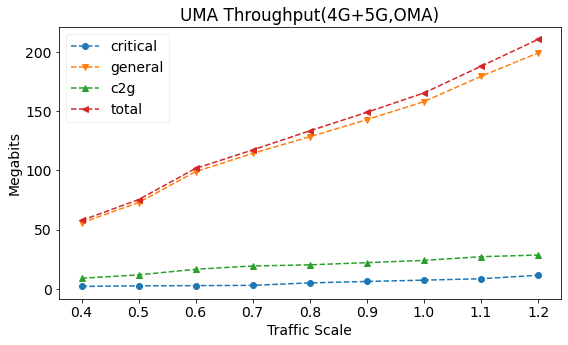

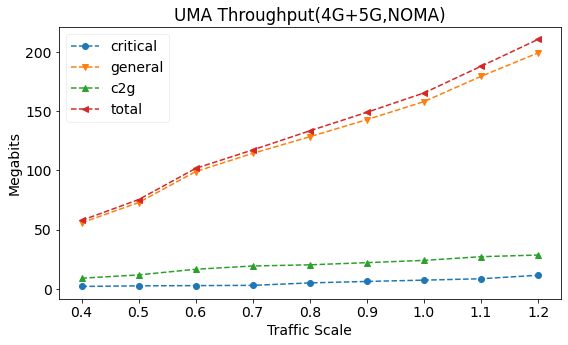

In [100]:
configs = [
    {
        "catalog": "bst-thrput",
        "topic": "Throughput",
        "x": "Traffic Scale",
        "y": "Megabits",
        "subject": [bs_type for bs_type in BaseStationType]
    },
]
# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for req_rsu in req_rsu_range:
            if(subject.name == "UMI" and req_rsu == False):
                continue
            for res_alloc_type in ResourceAllocatorType:
                title = "{} {}({},{})".format(
                    subject.name, 
                    topic,
                    BaseStationScenario(req_rsu),
                    AdjustResAllocTypeName(res_alloc_type)
                )
                plt.figure(serial, figsize=(9, 5))
                plt.xlabel(config["x"])
                plt.ylabel(config["y"])
                plt.title(title)
                line_no = 0
                if(subject.name=="UMI"):
                    nfts = [NetFlowType.CRITICAL]
                elif(subject.name =="UMA"):
                    if req_rsu:
                        nfts = NetFlowType
                    else:
                        nfts = [NetFlowType.CRITICAL, NetFlowType.GENERAL]
                nfts = list(map(lambda x: x.name,nfts)) + ["total"]
                for nft in nfts:
                    y = []
                    x = traffic_scale_range
                    for traffic_scale in traffic_scale_range:
                        value = []
                        for seed in seed_range:
                            v = stats[seed][res_alloc_type][req_rsu][traffic_scale][catalog][subject.name][nft]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v/(10**6))
                        y.append(sum(value)/len(value))
                    plt.plot(
                        x,
                        y,
                        GetLineMarkerStyle(line_no),
                        label="{}".format(
                            nft.lower(),
                        )
                    )
                    line_no += 1
                plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
                plt.savefig('{}/{}.pdf'.format(dirpath, title))
                serial += 1
plt.show()

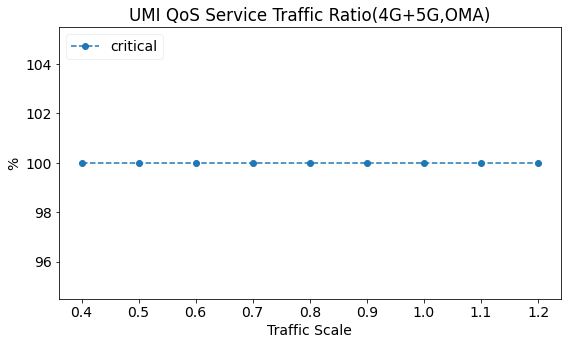

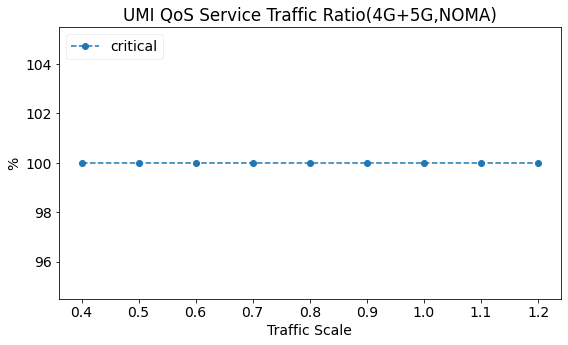

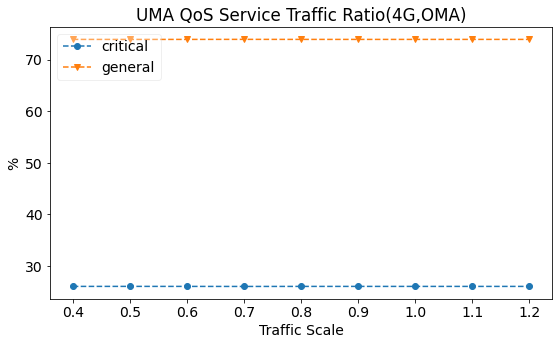

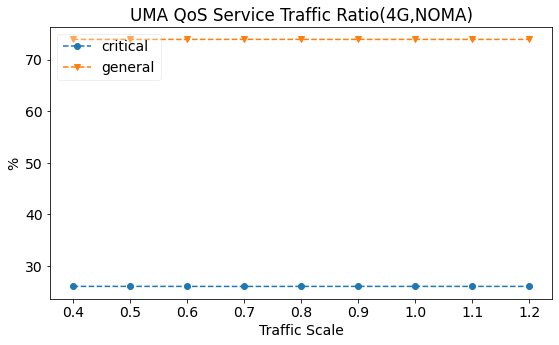

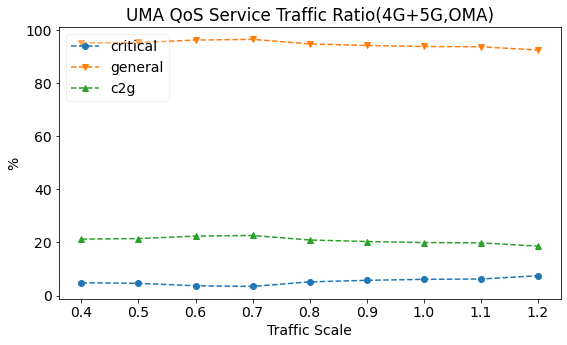

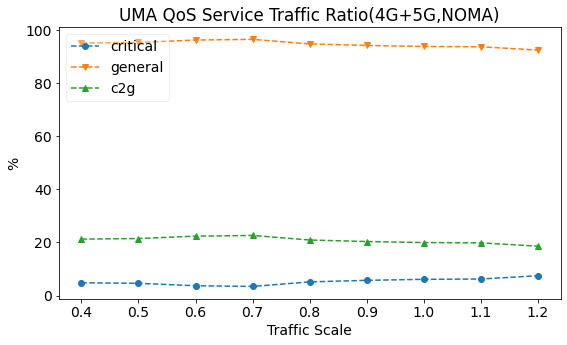

In [103]:
configs = [
    {
        "catalog": "bst-sg-rate",
        "topic": "QoS Service Traffic Ratio",
        "x": "Traffic Scale",
        "y": "%",
        "subject": [bs_type for bs_type in BaseStationType]
    },
]


# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    subjects = config["subject"]
    for subject in subjects:
        for req_rsu in req_rsu_range:
            if(subject.name == "UMI" and req_rsu == False):
                continue
            for res_alloc_type in ResourceAllocatorType:
                title = "{} {}({},{})".format(
                    subject.name, 
                    topic,
                    BaseStationScenario(req_rsu),
                    AdjustResAllocTypeName(res_alloc_type)
                )
                plt.figure(serial, figsize=(9, 5))
                plt.xlabel(config["x"])
                plt.ylabel(config["y"])
                plt.title(title)
                line_no = 0
                if(subject.name=="UMI"):
                    nfts = [NetFlowType.CRITICAL]
                elif(subject.name =="UMA"):
                    if req_rsu:
                        nfts = NetFlowType
                    else:
                        nfts = [NetFlowType.CRITICAL, NetFlowType.GENERAL]
                nfts = list(map(lambda x: x.name,nfts))
                for nft in nfts:
                    y = []
                    x = traffic_scale_range
                    for traffic_scale in traffic_scale_range:
                        value = []
                        for seed in seed_range:
                            v = stats[seed][res_alloc_type][req_rsu][traffic_scale][catalog][subject.name][nft]
                            if v == _pinf or v == _ninf:
                                v = 0
                            value.append(v*100)
                        y.append(sum(value)/len(value))
                    plt.plot(
                        x,
                        y,
                        GetLineMarkerStyle(line_no),
                        label="{}".format(
                            nft.lower(),
                        )
                    )
                    line_no += 1
                plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
                plt.savefig('{}/{}.pdf'.format(dirpath, title))
                serial += 1
plt.show()

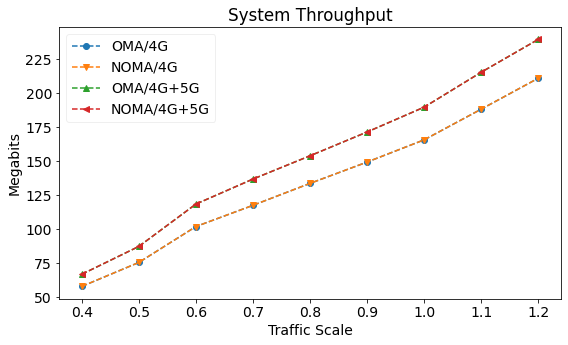

In [105]:
configs = [
    {
        "catalog": "sys-thrput",
        "topic": "System Throughput",
        "x": "Traffic Scale",
        "y": "Megabits",
    },
]


# intialize
_pinf = float("inf")
_ninf = float("-inf")
serial = 1
for config in configs:
    catalog = config["catalog"]
    topic = config["topic"]
    title = topic
    plt.figure(serial, figsize=(9, 5))
    plt.xlabel(config["x"])
    plt.ylabel(config["y"])
    plt.title(title)
    line_no = 0
    for req_rsu in req_rsu_range:
        for res_alloc_type in ResourceAllocatorType:
            y = []
            x = traffic_scale_range
            for traffic_scale in traffic_scale_range:
                value = []
                for seed in seed_range:
                    v = stats[seed][res_alloc_type][req_rsu][traffic_scale][catalog]["total"]
                    if v == _pinf or v == _ninf:
                        v = 0
                    value.append(v/10**6)
                y.append(sum(value)/len(value))
            plt.plot(
                x,
                y,
                GetLineMarkerStyle(line_no),
                label="{}/{}".format(
                    AdjustResAllocTypeName(res_alloc_type),
                    BaseStationScenario(req_rsu)
                )
            )
            line_no += 1
    plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
    plt.savefig('{}/{}.pdf'.format(dirpath, title))
    serial += 1
plt.show()